In [17]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)  # Replace 100 with the desired number
pd.set_option('display.max_columns', 200)  # Replace 100 with the desired number

In [18]:
data = pd.read_csv('../../data/147_properties.csv', sep = ',')

/var/folders/r7/5qjvym7502z0hk7l29b80j640000gn/T/ipykernel_51874/402623131.py:1: DtypeWarning: Columns (2,3,4,28,34,35,56,61,64,69,82,87,88,90,91,92,93,94,95,96,104,109,110,117,118,119,122,127,130,135,138,143,145,146,148,149,150,151,152,154,155,156,157,158,160,161,162,163,164,166,167,168,169,170,171,172,175,177,178,180,181,182,183,184,186,187,188,189,190,191,192,197,199,200,207,215,217,218,219,220,221,222,223,224,225,228,233,236,241,242,244,245,246,247,250,252,254,255,256,257,258,259,260,261,262,263,264,265,266,268,269,271,272,274,279,280,281,284,286,287,290,291,292,295,296,297,298,299,300,302,303,304,308,309,311,313,316,318,319,321,324,329,331,333,334,335,336,338,339,342,343,344,347,351,354,357,360,363,366,367,368,369,370,374,377,380,383,386,389,392,395,398,401,404,407,410,413,416,419,422,425,433,437,438,439,440,443,445,446,447,448,449,451,452,455,456,457,460,463,466,471,472,477,478,483,484,489,490,495,496,501,502,507,508,513,514,519,520,525,526,531,532,537,538,543,544,549,550,555,556

In [21]:
thresh = len(data) * 0.6
# Drop columns with more than 40% NaN values
df_cleaned = data.dropna(axis=1, thresh=thresh)

In [22]:
df_cleaned = df_cleaned[df_cleaned['props_pageProps_address_events_0_label'] == 'Fri handel']
#df_cleaned = df_cleaned[df_cleaned['props_pageProps_dataLayer_detailPropertyClass'] == 'ejerlejlighed']

In [23]:
cols = ['props_pageProps_address_buildings_0_bathroomCondition', 'props_pageProps_address_buildings_0_buildingName',
        'props_pageProps_address_buildings_0_externalWallMaterial', 'props_pageProps_address_buildings_0_heatingInstallation',
        'props_pageProps_address_buildings_0_housingArea', 'props_pageProps_address_buildings_0_kitchenCondition', 'props_pageProps_address_buildings_0_numberOfFloors',
        'props_pageProps_address_buildings_0_numberOfToilets', 'props_pageProps_address_buildings_0_roofingMaterial', 'props_pageProps_address_buildings_0_toiletCondition',
        'props_pageProps_address_buildings_0_yearBuilt', 'props_pageProps_address_municipality_name', 'props_pageProps_address_coordinates_lat', 'props_pageProps_address_coordinates_lon',
        'props_pageProps_address_floor', 'props_pageProps_address_municipality_numberOfSchools', 'props_pageProps_address_municipality_population', 'props_pageProps_address_events_0_at',
        'props_pageProps_address_events_0_label', 'props_pageProps_dataLayer_virtualPagePath', 'props_pageProps_dataLayer_detailPropertyClass', 'lastPrice']

In [25]:
# Extract price from string

def extract_last_price(s):
    last_price_match = re.search(r'lastPrice:(\d+)', s)
    return int(last_price_match.group(1)) if last_price_match else None

df_cleaned['lastPrice'] = df_cleaned['props_pageProps_dataLayer_detailMetaData'].apply(extract_last_price)

df_cleaned['sqm_price'] = df_cleaned['lastPrice'] / df_cleaned['props_pageProps_address_buildings_0_housingArea']

df_cleaned = df_cleaned[cols]

In [29]:
df_cleaned.to_csv('../../data/testClean.csv', index = False)

In [27]:
df_cleaned['lastPrice'].describe()

count    3.314000e+03
mean     1.518312e+07
std      2.793101e+07
min      2.400000e+04
25%      1.857990e+06
50%      3.700000e+06
75%      1.400000e+07
max      1.395250e+08
Name: lastPrice, dtype: float64

<Axes: >

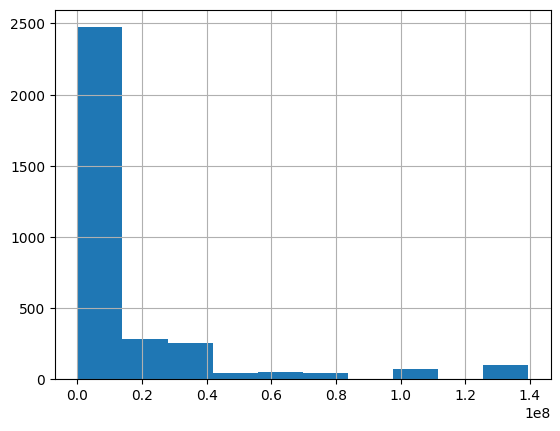

In [28]:
df_cleaned['lastPrice'].hist()

In [2]:
import os 

os.getcwd()

'/Users/shakirmshaker/Library/Mobile Documents/com~apple~CloudDocs/Skole/DTU/ComputationalTools/Project/notebooks/ShakirMaythamShaker'